# Библиотеки

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
from math import *
# from iminuit import Minuit
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LinearSegmentedColormap
%pylab inline
import warnings
from scipy import stats
from scipy.integrate import quad
import plotly.express as px
from scipy import stats
from scipy import interpolate
import torch.utils.data as data_utils
warnings.filterwarnings('ignore')
plt.rcParams['font.size']=15
from google.colab import drive

import torch # PyTorch package
import torchvision # load datasets
import torchvision.transforms as transforms # transform data
import torch.nn as nn # basic building block for neural neteorks
import torch.nn.functional as F # import convolution functions like Relu
import torch.optim as optim # optimzer
from sklearn.model_selection import train_test_split

mp=1.001
mN=14.007
mFe=55.845
m=np.array([mp,mN,mFe])
ln_m=np.log(m+0.1)

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.9/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['ceil', 'fmod', 'hypot', 'isfinite', 'trunc', 'frexp', 'tan', 'nextafter', 'nan', 'remainder', 'log', 'log2', 'sqrt', 'lcm', 'e', 'floor', 'gamma', 'pi', 'fabs', 'modf', 'inf', 'ldexp', 'sin', 'exp', 'log10', 'expm1', 'radians', 'copysign', 'isclose', 'sinh', 'degrees', 'isinf', 'isnan', 'cos', 'log1p', 'gcd', 'tanh', 'cosh', 'prod']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# Загрузка данных

In [ ]:
drive.mount('/content/drive')
direct='drive/MyDrive/neuro/mosaic_hits/1/'

# Для первой модели взаимодействия ================================
p_q1=np.load( direct+'glob_array_p_q1.npy')   
p_q1.shape

Mounted at /content/drive


(54450000,)

In [ ]:
drive.mount('/content/drive')
direct='drive/MyDrive/neuro/mosaic_hits/1/'

# Для первой модели взаимодействия ================================
p_q1=np.load( direct+'glob_array_p_q1.npy')   
p_q1=p_q1.reshape(6000,75,11,11,1)

# p=p[:,:50]    # Лучше до 50 кадров пробовать, дальше нет полезной информации

N_q1=np.load( direct+'glob_array_N_q1.npy')   
N_q1=N_q1.reshape(6000,75,11,11,1)

Fe_q1=np.load( direct+'glob_array_Fe_q1.npy')   
Fe_q1=Fe_q1.reshape(6000,75,11,11,1)

# Для второй модели взаимодействия =================================
direct='drive/MyDrive/neuro/mosaic_hits/2/'

p_q2=np.load( direct+'glob_array_p.npy')   
p_q2=p_q2.reshape(6000,75,11,11,1)

N_q2=np.load( direct+'glob_array_N.npy')   
N_q2=N_q2.reshape(6000,75,11,11,1)

Fe_q2=np.load( direct+'glob_array_Fe.npy')   
Fe_q2=Fe_q2.reshape(6000,75,11,11,1)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Проверка, что загрузка прошла успешно

In [ ]:
fig=plt.figure()
stop_cadre=75
for j in range(10):
  for i in range(stop_cadre):
    plt.scatter(i,np.count_nonzero(p[j,i,:,:]),color='blue',alpha=0.1)
# plt.savefig('nonzero_cadre.png')

Создаем X и y из 36 000 событий.

In [ ]:
X=np.concatenate((p_q1,N_q1,Fe_q1,p_q2,N_q2,Fe_q2),axis=0)   # p, N, Fe, p, N, Fe    --- последовательность такая
print( 'X shape = ', X.shape)

# В качетсве y действительные числа, логарифма массы соответствующих ядер
# y=np.concatenate((np.array([ln_m[0]]*6000),np.array([ln_m[1]]*6000),np.array([ln_m[2]]*6000),
#               np.array([ln_m[0]]*6000),np.array([ln_m[1]]*6000),np.array([ln_m[2]]*6000)),axis=0)

# В качетсве y в будущем целые числа, 0, 1, 2 
y=np.concatenate((np.array([0]*6000),np.array([1]*6000),np.array([2]*6000),
              np.array([0]*6000),np.array([1]*6000),np.array([2]*6000)),axis=0)
print( 'y shape = ', y.shape)

X shape =  (36000, 75, 11, 11, 1)
y shape =  (36000,)


In [ ]:
X = X.reshape(36000, 1, 75, 11, 11)

In [ ]:
batch_size = 64

#X=X.reshape(36000,75,11,11)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=33, shuffle=True)

train_dat    = torch.utils.data.TensorDataset(torch.tensor(np.float32(X_train)), torch.tensor(np.float32(y_train)).type(torch.LongTensor))
train_loader = torch.utils.data.DataLoader(train_dat, batch_size = 16, shuffle = True)

test_dat    = torch.utils.data.TensorDataset(torch.tensor(np.float32(X_test)), torch.tensor(np.float32(y_test)).type(torch.LongTensor))
test_loader = torch.utils.data.DataLoader(test_dat, batch_size = 16, shuffle = False)


# Архитектура сети

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv3d(1, 8, 3, stride=1, padding=1)
        self.conv2 = nn.Conv3d(8, 16, 3, stride=1, padding=1)

        self.pool = nn.MaxPool3d(2, 2)
        self.conv3 = nn.Conv3d(16, 32, 3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 3 * 3, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)#, momentum=0.9)

In [ ]:
net

Net(
  (conv1): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv2): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (fc1): Linear(in_features=288, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=3, bias=True)
)

In [ ]:
for epoch in range(15):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

Finished Training


In [ ]:
classes=['p','N','Fe']
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  N     N     N     N    


In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 51 %


In [ ]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: p     is 64.5 %
Accuracy for class: N     is 0.0 %
Accuracy for class: Fe    is 72.4 %


# Исследование

Очистка памяти

In [ ]:
# Очистка памяти
from numba import cuda 
device = cuda.get_current_device()
device.reset()

In [ ]:
# get some random training images
# trainloader = torch.utils.data.DataLoader(p_q1, batch_size=batch_size,
#                                           shuffle=True, num_workers=num_workers)
# dataiter = iter(trainloader)
# images = next(dataiter)

# dataiter = iter(trainloader)
# images = next(dataiter)

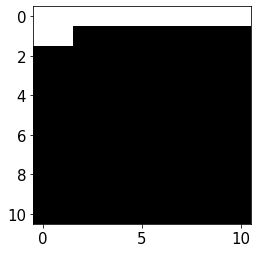

In [ ]:
def imshow(img):
    # img = img / 2 + 0.5     # unnormalize

    npimg = img.numpy()
    # print(np.transpose(npimg, (1, 2, 0)))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()



# show images

imshow(torchvision.utils.make_grid(images[0][3]))
# print labels
# print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

Как добавить y компоненту к тензору или numpy?

In [ ]:
dataloaders_train = torch.utils.data.DataLoader(Xt_train, batch_size=64)

Yt_train = Yt_train.type(torch.LongTensor)
dataloaders_test = torch.utils.data.DataLoader(Yt_train, batch_size=64)

class Network(nn.Module):
    def __init__(self):
        super().__init__()


        self.hidden = nn.Linear(42000, 256)

        self.output = nn.Linear(256, 10)


        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):

        x = self.hidden(x)
        x = self.sigmoid(x)
        x = self.output(x)
        x = self.softmax(x)

        return x

model = Network()

input_size = 784
hidden_sizes = [28, 64]
output_size = 10 
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.Softmax(dim=1))
print(model)

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)

epochs = 5

for e in range(epochs):
    running_loss = 0
    for images, labels in zip(dataloaders_train, dataloaders_test):

        images = images.view(images.shape[0], -1)
        #images, labels = Variable(images), Variable(labels)
        print(images.dtype)
        print(labels.dtype)

        optimizer.zero_grad()

        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss}")